In [9]:
import pandas as pd
import numpy as np
from collections import Counter
import scipy
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
from best_fit_dist import *

import warnings 
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb


# Table of Contents
### 1. Problem Statement
### 2. Exploratory Data Analysis
### 3. Data Cleaning and Preparation
### 4. Feature Engineering
### 5. Modeling
### 6. Conclusion



## 1. Problem Statement
The WiDS Datathon 2022 focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.
### Features 
There are 63 independent variables in the dataset.
### Target
site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

## 2. Import data Exploratory Data Analysis

In [10]:
path = '/Users/rsati/Downloads/wids2022/'
train = pd.read_csv(path + 'data/train.csv'); print('train shape', train.shape)
test = pd.read_csv(path + 'data/test.csv'); print('test shape', test.shape)
sample_solution = pd.read_csv(path + 'data/sample_solution.csv'); print('output shape', sample_solution.shape)


train shape (75757, 64)
test shape (9705, 63)
output shape (9705, 2)


### Study of Target Variable

Target variable is continuous, so we checking the shape and best fit distribution.

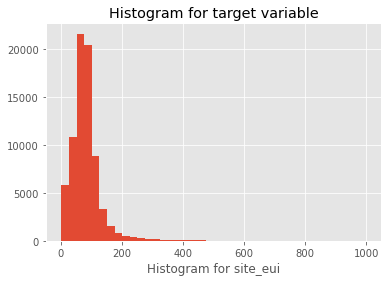

count    75757.000000
mean        82.584693
std         58.255403
min          1.001169
25%         54.528601
50%         75.293716
75%         97.277534
max        997.866120
Name: site_eui, dtype: float64

In [11]:
train.site_eui.hist(bins = 40)
plt.xlabel('Histogram for site_eui')
plt.title('Histogram for target variable')
plt.show()
train.site_eui.describe()

  1 / 5  : gamma
  2 / 5  : beta
  3 / 5  : rayleigh
  4 / 5  : norm
  5 / 5  : pareto


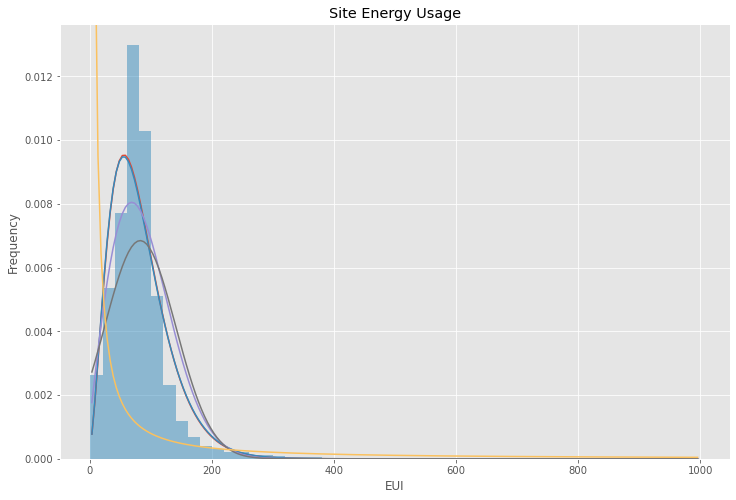

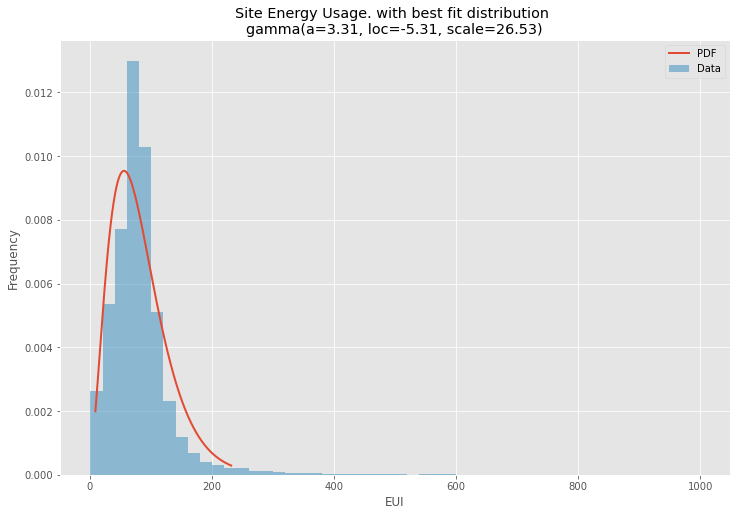

In [12]:
# Load data from statsmodels datasets
data = pd.Series(train.site_eui)
dist_list = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']
best_dist_exe(data, dist_list)


### Target Vs Features Study

In [13]:
cat_columns = ['Year_Factor', 'State_Factor', 'building_class', 'facility_type']

In [14]:
def hist_across_category (col_name) :
    df_inp = pd.Series(train[col_name])
    k = 0
    for x in np.unique(df_inp) :
        filtered_eui = train.site_eui[df_inp == x]
        k = k + 1
        plt.subplot(len(np.unique(df_inp)), 1, k)
        plt.hist(filtered_eui, bins = 50, alpha = 0.6, color = 'green', label=str(x))
        plt.legend(loc='upper right')  
        
    plt.show()
    
def scatter_plot_cont_var (col_name) :
    df_inp = train[[col_name, 'site_eui']]
    print(df_inp.corr())
    df_inp.columns = ['x', 'site_eui']
    df_inp.plot.scatter(x = 'x', y = 'site_eui', marker = 'o', figsize=(6,4), title = '{} with site_eui'.format(col_name))
    
    
def binning_cont (col_name, no_of_bins) :
    bins_column = col_name + "_bins"
    train_sub = train[['site_eui', col_name, 'id']]
    train_sub[bins_column] = pd.cut(train_sub[col_name], bins = no_of_bins)
    train_temp = (
        train_sub[['site_eui', bins_column]]
        .groupby(bins_column)
        .agg(['mean', 'std'])
        .reset_index())
    train_temp.columns = [bins_column, col_name + "_mean", col_name + "_std"]
    train_temp[col_name + "_cv"] = 100*train_temp[col_name + "_std"]/train_temp[col_name + "_mean"]
    train_sub = train_sub.merge(train_temp, on = bins_column, how = 'left')
    return train_sub[['id', bins_column, col_name + "_mean", col_name + "_std", col_name + "_cv"]]

In [15]:
train['tentative_year_measured'] = 2014 + train.Year_Factor
train['tentative_days_denom'] = 365*(train.tentative_year_measured - train.year_built)

days_with_vars = ['days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F', 
                  'days_above_90F', 'days_above_100F', 'days_above_110F', 'days_with_fog']

temp_related_vars = ['january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp']

### Histogram plot of variables with their levels 

Variation with Year_Factor


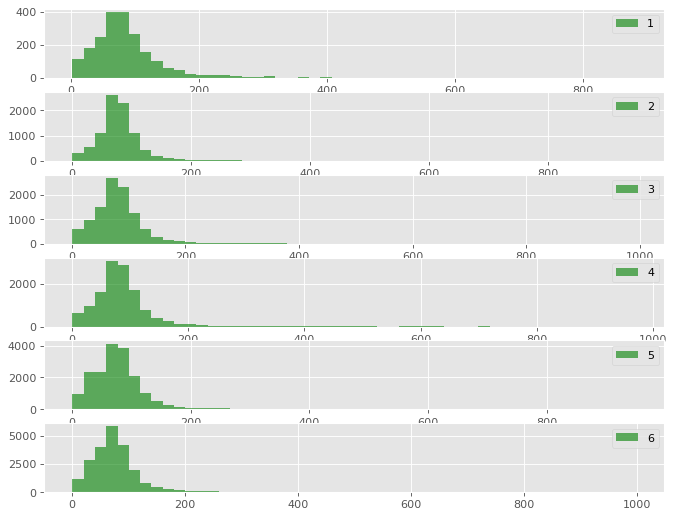

In [16]:
print('Variation with Year_Factor')
figure(figsize = (10, 8), dpi = 80)
hist_across_category('Year_Factor')


From the above histogram chart across different Year Factor, we observe that data has a mean of about 120 across all the years, however, there are values to the higher side indicating right skewed. 
These looks like outlier, however, they can be important points for our model predictions.

Variation with State Factor


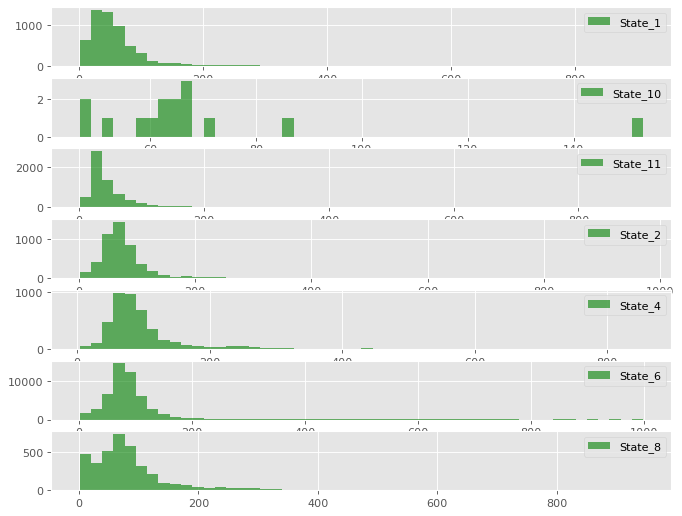

In [17]:
print('Variation with State Factor')
figure(figsize = (10, 8), dpi = 80)
hist_across_category('State_Factor')

Histograms shows the distribution of target variable across the different states. State-10 shows very different distribution from others.

Variation with Building Class


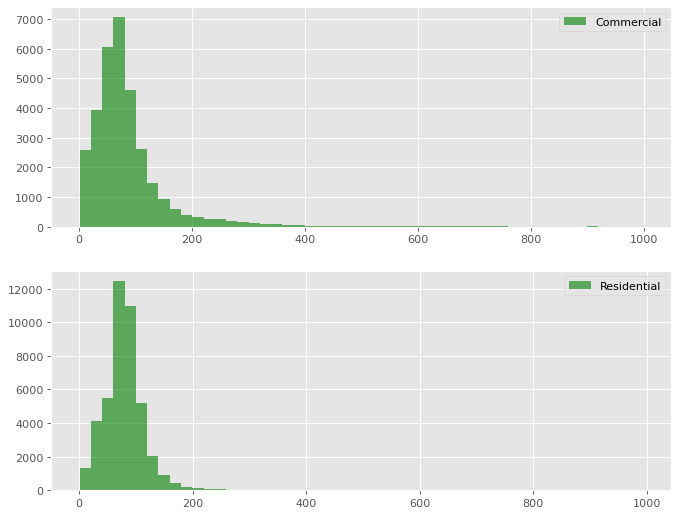

In [18]:
print('Variation with Building Class')
figure(figsize = (10, 8), dpi = 80)
hist_across_category('building_class')

Variation in Commercial buiilding have right skewed distribution. This makes sense as commercial buildings that might be open 24 hours for production might be consuming alot of energy.

### Scatter plot and correlation of different variables with respect to Target

            floor_area  site_eui
floor_area    1.000000  0.073967
site_eui      0.073967  1.000000


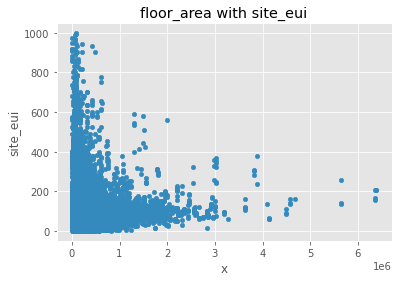

In [19]:
scatter_plot_cont_var(col_name= 'floor_area')

                    energy_star_rating  site_eui
energy_star_rating            1.000000 -0.511012
site_eui                     -0.511012  1.000000


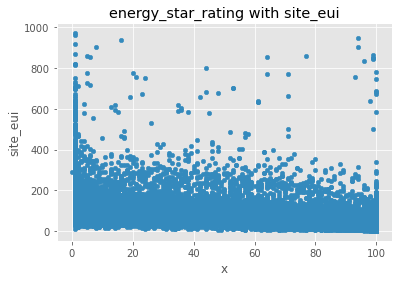

In [20]:
scatter_plot_cont_var('energy_star_rating')

           ELEVATION  site_eui
ELEVATION   1.000000  0.011798
site_eui    0.011798  1.000000


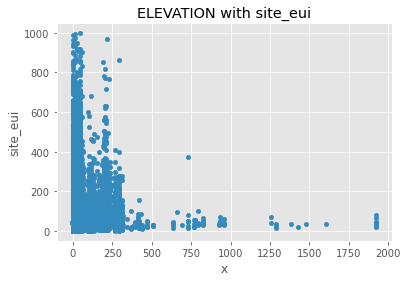

In [21]:
scatter_plot_cont_var('ELEVATION')

                     cooling_degree_days  site_eui
cooling_degree_days             1.000000  0.125004
site_eui                        0.125004  1.000000


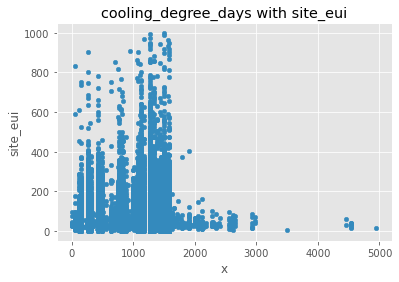

In [22]:
scatter_plot_cont_var('cooling_degree_days')

                      precipitation_inches  site_eui
precipitation_inches              1.000000  0.113558
site_eui                          0.113558  1.000000


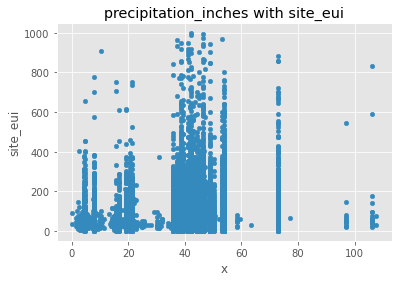

In [23]:
scatter_plot_cont_var('precipitation_inches')

                 snowfall_inches  site_eui
snowfall_inches         1.000000  0.157284
site_eui                0.157284  1.000000


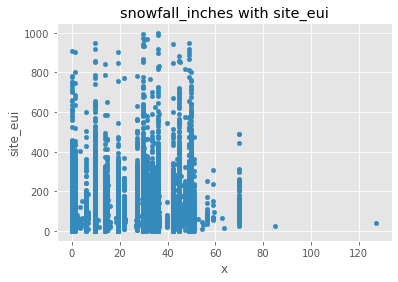

In [24]:
scatter_plot_cont_var('snowfall_inches')

                  snowdepth_inches  site_eui
snowdepth_inches          1.000000  0.113371
site_eui                  0.113371  1.000000


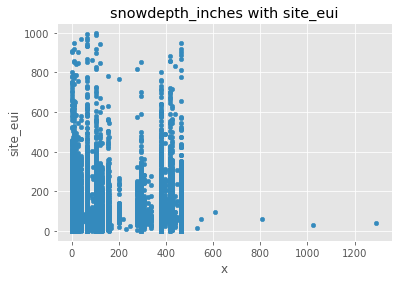

In [25]:
scatter_plot_cont_var('snowdepth_inches')

          avg_temp  site_eui
avg_temp  1.000000 -0.089201
site_eui -0.089201  1.000000


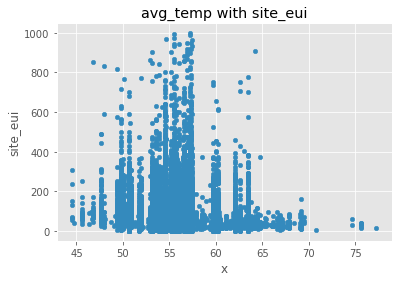

In [26]:
scatter_plot_cont_var('avg_temp')

                          direction_max_wind_speed  site_eui
direction_max_wind_speed                  1.000000  0.010217
site_eui                                  0.010217  1.000000


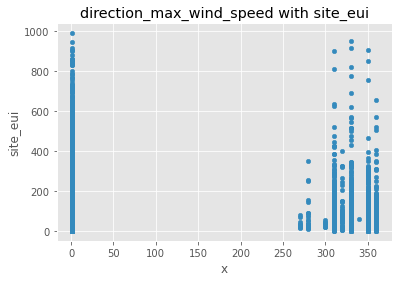

In [27]:
scatter_plot_cont_var('direction_max_wind_speed')

                           direction_peak_wind_speed  site_eui
direction_peak_wind_speed                   1.000000  0.013589
site_eui                                    0.013589  1.000000


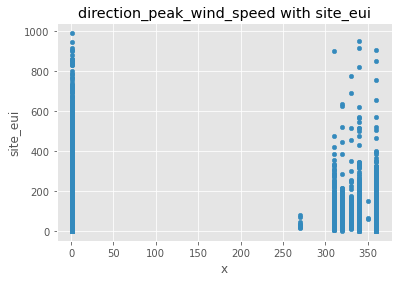

In [28]:
scatter_plot_cont_var('direction_peak_wind_speed')

                max_wind_speed  site_eui
max_wind_speed        1.000000  0.010639
site_eui              0.010639  1.000000


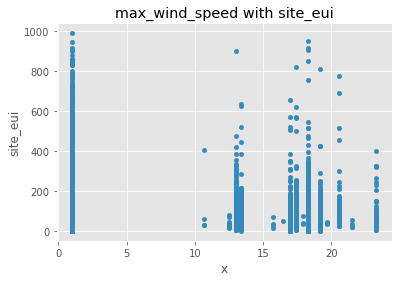

In [29]:
scatter_plot_cont_var('max_wind_speed')

## Features comparison distribution study across train and test

#### Here we are comparing how data is distributed across training and test set. One important point to note is that training set has data for year-factor between 1 and 6, however, test dataset has data for year-factor 7.

In [30]:
def count_df_comp (col_name) :
    train_df = pd.Series(train[col_name])
    test_df = pd.Series(test[col_name])
    output_df = (pd.DataFrame.from_dict(Counter(train_df), orient = 'index')
                 .reset_index()
                 .merge(pd.DataFrame.from_dict(Counter(test_df), orient = 'index')
                        .reset_index(),
                        on = 'index', how = 'outer'))
    output_df.columns = ['index', 'train', 'test']
    return output_df
    

def continuous_comp (col_name, TITLE) :
    plt.figure(figsize = (8,6))
    plt.hist(train[col_name], bins = 50, alpha = 0.5, color = 'blue', label = 'train', density = True)
    plt.hist(test[col_name], bins = 50, alpha = 0.2, color = 'red', label = 'test', density = True)
    plt.legend()
    plt.title(TITLE)
    plt.show()
    print(train[col_name].describe(), test[col_name].describe())

In [31]:
test['tentative_year_measured'] = 2014 + test.Year_Factor
test['tentative_days_denom'] = 365*(test.tentative_year_measured - test.year_built)

In [32]:
print('Year-factor between Train and Test set')
count_df_comp('Year_Factor')

Year-factor between Train and Test set


,index,train,test
0,1,2117.0,NaN
1,2,9058.0,NaN
2,3,10879.0,NaN
3,4,12946.0,NaN
4,5,18308.0,NaN
5,6,22449.0,NaN
6,7,NaN,9705.0


Training set has data for year-factor between 1 and 6, however, test dataset has data for year-factor 7.

In [33]:
print('State_Factor between Train and Test set')
count_df_comp('State_Factor')

State_Factor between Train and Test set


,index,train,test
0,State_1,5618,1027.0
1,State_2,4871,1515.0
2,State_4,4300,2568.0
3,State_6,50840,NaN
4,State_8,3701,1323.0
5,State_10,15,4.0
6,State_11,6412,3268.0


State-6 is missing in Test set, however, in training set it has highest number of data points (rows).

In [34]:
print('Building-class between Train and Test set')
count_df_comp('building_class')

Building-class between Train and Test set


,index,train,test
0,Commercial,32199,5607
1,Residential,43558,4098


### Comparing continuoud data between train and test set

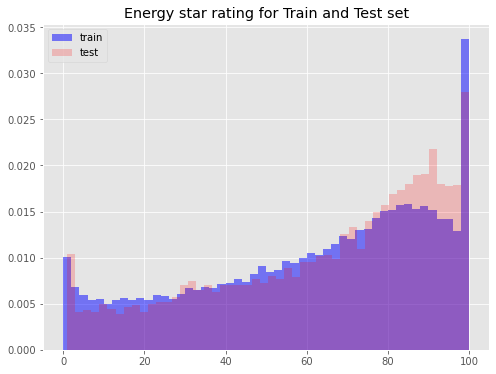

count    49048.000000
mean        61.048605
std         28.663683
min          0.000000
25%         40.000000
50%         67.000000
75%         85.000000
max        100.000000
Name: energy_star_rating, dtype: float64 count    7451.000000
mean       64.712924
std        27.935984
min         1.000000
25%        45.000000
50%        72.000000
75%        88.000000
max       100.000000
Name: energy_star_rating, dtype: float64


In [35]:
continuous_comp('energy_star_rating', TITLE = 'Energy star rating for Train and Test set')

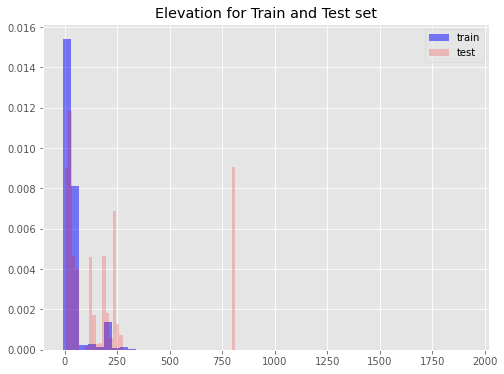

count    75757.000000
mean        39.506323
std         60.656596
min         -6.400000
25%         11.900000
50%         25.000000
75%         42.700000
max       1924.500000
Name: ELEVATION, dtype: float64 count    9705.000000
mean      205.231190
std       264.822814
min         1.800000
25%        26.500000
50%       118.900000
75%       231.300000
max       812.000000
Name: ELEVATION, dtype: float64


In [36]:
continuous_comp('ELEVATION', TITLE = 'Elevation for Train and Test set')

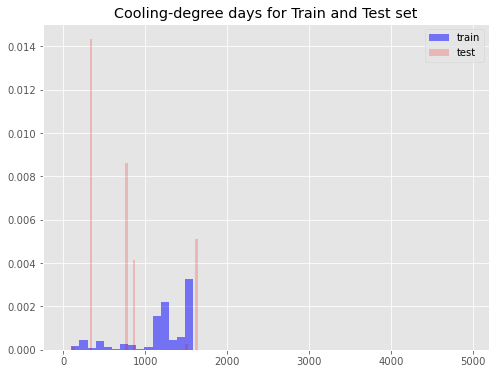

count    75757.000000
mean      1202.250446
std        391.561780
min          0.000000
25%       1128.000000
50%       1277.000000
75%       1489.000000
max       4948.000000
Name: cooling_degree_days, dtype: float64 count    9705.000000
mean      733.361875
std       452.168118
min       110.000000
25%       345.000000
50%       761.000000
75%       866.000000
max      1643.000000
Name: cooling_degree_days, dtype: float64


In [37]:
continuous_comp('cooling_degree_days', TITLE = 'Cooling-degree days for Train and Test set')


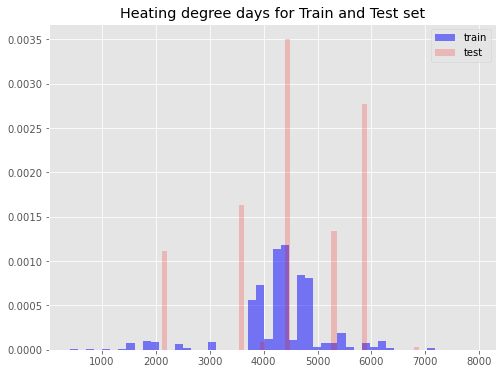

count    75757.000000
mean      4324.957390
std        824.366727
min        398.000000
25%       3978.000000
50%       4337.000000
75%       4670.000000
max       7929.000000
Name: heating_degree_days, dtype: float64 count    9705.000000
mean     4565.202061
std      1165.539843
min      2112.000000
25%      3555.000000
50%      4478.000000
75%      5907.000000
max      6877.000000
Name: heating_degree_days, dtype: float64


In [38]:
continuous_comp('heating_degree_days', TITLE = 'Heating degree days for Train and Test set') 

## 3. Data Cleaning and Preparation

### Missing Value

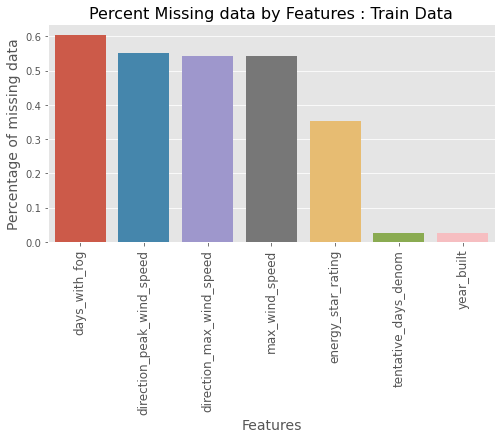

In [39]:
all_data_na = (train.isnull().sum()/train.shape[0]).sort_values(ascending= False)
all_data_na= all_data_na.drop(all_data_na[all_data_na==0].index)
missing_data = pd.DataFrame({'missing_ratio':all_data_na})

plt.subplots(figsize = (8,4))
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Percentage of missing data', fontsize= 14)
plt.title('Percent Missing data by Features : Train Data', fontsize=16)
plt.xticks(rotation= 90, fontsize= 12)
plt.show()

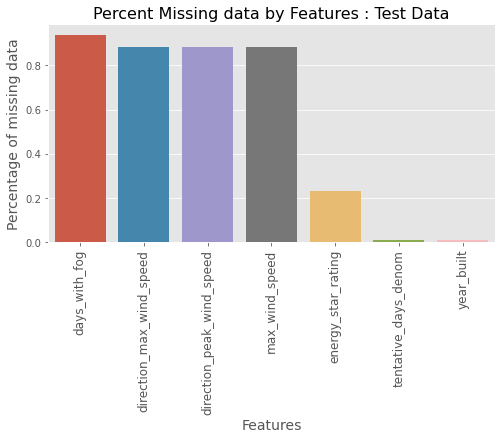

In [40]:
all_data_na = (test.isnull().sum()/test.shape[0]).sort_values(ascending= False)
all_data_na= all_data_na.drop(all_data_na[all_data_na==0].index)
missing_data = pd.DataFrame({'missing_ratio':all_data_na})

plt.subplots(figsize = (8,4))
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Percentage of missing data', fontsize= 14)
plt.title('Percent Missing data by Features : Test Data', fontsize=16)
plt.xticks(rotation= 90, fontsize= 12)
plt.show()

### Missing value imputation
Imputing NaN year with the current year - 2022. 

Replacing days with fog with null values with 0.

For other numerical values, replacing NULL values with mean.

In [41]:
# Replace NA and 0 values with current year
train.loc[(train.year_built.isnull()) | (train.year_built== 0), 'year_built']= 2022
test.loc[(test.year_built.isnull()) | (test.year_built== 0), 'year_built']= 2022

# Replace NA 'days_with_fog' with 0
train['days_with_fog'] = train['days_with_fog'].fillna(0)
test['days_with_fog'] = test['days_with_fog'].fillna(0)

# Impute with mean
null_col=['direction_peak_wind_speed', 'max_wind_speed', 'direction_max_wind_speed', 'energy_star_rating']


### Label encoding the categorical variable

Categorical columns are encoded using Label encoding. LightGBM is capable of using label encoded target variables for modeling.

In [42]:
def label_encoding(df_data, df_test, cat_cols):
    for col in cat_cols:
        lb = LabelEncoder()
        lb.fit(pd.concat([df_data[col], df_test[col]]))
        df_data[col] = lb.transform(df_data[col])
        df_test[col] = lb.transform(df_test[col])
    return df_data, df_test

In [43]:
df_data, df_test = train, test

CAT_COLS = ['State_Factor', 'building_class', 'facility_type', 'year_built']
UNUSED_FEATS = ['Year_Factor', 'direction_max_wind_speed', 'direction_peak_wind_speed'
                , 'site_eui', 'id', 'days_above_110F', 'days_above_100F', 'days_below_0F','days_below_20F']

NUM_COLS = [c for c in df_data.columns if c not in CAT_COLS + UNUSED_FEATS]
FEATURES = [c for c in df_data.columns if c not in UNUSED_FEATS]
CAT_IDX = [i for i, c in enumerate(FEATURES) if c in CAT_COLS]

df_data, df_test = label_encoding(df_data, df_test, CAT_COLS)


Using above categorical columns and numerical columns in the final model. Some variables, that we identified in the EDA step, were not useful and are being not used for training the model.

## 4. Feature Engineering

In [44]:
def do_feature_binning(df_data, df_test, col:str, bins:int, qcut_flag:bool=False):
    if qcut_flag:
        df_data[f'{col}_buckets'], bins = pd.qcut(df_data[col], bins, retbins=True
                                              , labels=False, duplicates='drop')
    else:
        df_data[f'{col}_buckets'], bins = pd.cut(df_data[col], bins, retbins=True
                                              , labels=False, duplicates='drop')
        
    bins = np.array([-np.inf] + list(bins)[1:-1] + [np.inf])
    df_test[f'{col}_buckets'] = pd.cut(df_test[col], bins, labels=False)
    
    return df_data, df_test, f'{col}_buckets'

def get_cat_group_continous(df_data, df_test, cat_col, col):
    df = pd.concat([df_data, df_test], axis=0, ignore_index=True)
    df_ = df.groupby(cat_col)[col].mean()
    df_data[f'{cat_col}_{col}_mean'] = df_data[cat_col].map(df_)
    df_test[f'{cat_col}_{col}_mean'] = df_test[cat_col].map(df_)
    
    df_ = df.groupby(cat_col)[col].median()
    df_data[f'{cat_col}_{col}_median'] = df_data[cat_col].map(df_)
    df_test[f'{cat_col}_{col}_median'] = df_test[cat_col].map(df_)
    
    df_ = df.groupby(cat_col)[col].std()
    df_data[f'{cat_col}_{col}_std'] = df_data[cat_col].map(df_)
    df_test[f'{cat_col}_{col}_std'] = df_test[cat_col].map(df_)
    
    return df_data, df_test

To make model more robust, added mean and median features for the temperature, year built and energy star columns.

In [45]:
df_data, df_test, col = do_feature_binning(df_data, df_test, 'ELEVATION', 5)

In [46]:
for cat_col in ['facility_type', 'year_built', 'building_class', 'State_Factor']:
    for col in ['energy_star_rating', 'floor_area', 'ELEVATION', 'days_with_fog', 'january_avg_temp'
               , 'max_wind_speed', 'july_avg_temp', 'april_avg_temp', 'november_max_temp']:
        df_data, df_test = get_cat_group_continous(df_data, df_test, cat_col, col)
        

In [47]:
ADDED_FEATS = ['ELEVATION_buckets', 'facility_type_energy_star_rating_mean',
             'facility_type_energy_star_rating_median', 'facility_type_energy_star_rating_std',
             'facility_type_floor_area_mean', 'facility_type_floor_area_median',
             'facility_type_ELEVATION_mean', 'facility_type_days_with_fog_mean',
             'facility_type_days_with_fog_std', 'facility_type_january_avg_temp_mean',
             'facility_type_january_avg_temp_median', 'facility_type_max_wind_speed_std',
             'facility_type_november_max_temp_std', 'year_built_energy_star_rating_mean',
             'year_built_energy_star_rating_median', 'year_built_energy_star_rating_std',
             'year_built_floor_area_mean', 'year_built_floor_area_median',
             'year_built_floor_area_std', 'year_built_ELEVATION_mean',
             'year_built_ELEVATION_median', 'year_built_ELEVATION_std',
             'year_built_january_avg_temp_mean', 'year_built_january_avg_temp_median',
             'year_built_january_avg_temp_std', 'year_built_max_wind_speed_mean',
             'year_built_max_wind_speed_median', 'year_built_july_avg_temp_mean',
             'year_built_july_avg_temp_std', 'year_built_april_avg_temp_mean',
             'year_built_april_avg_temp_std', 'year_built_november_max_temp_mean',
             'year_built_november_max_temp_median', 'year_built_november_max_temp_std',
             'building_class_energy_star_rating_mean', 'State_Factor_energy_star_rating_mean',
             'State_Factor_floor_area_mean', 'State_Factor_floor_area_median',
             'State_Factor_ELEVATION_mean', 'State_Factor_ELEVATION_median',
             'State_Factor_days_with_fog_median', 'State_Factor_january_avg_temp_std',
             'State_Factor_april_avg_temp_std']


## 5. Modeling

In [48]:
TARGET = 'site_eui'
CAT_COLS = ['State_Factor', 'building_class', 'facility_type', 'year_built']
UNUSED_FEATS = ['Year_Factor', 'direction_max_wind_speed', 'direction_peak_wind_speed'
                , 'site_eui', 'id', 'days_above_110F', 'days_above_100F', 'days_below_0F','days_below_20F']


In [49]:
def get_validation(df_data, year_flag:bool=True, n_splits:int=5):
    splits = []
    if year_flag:
        for year in df_data['Year_Factor'].unique():
            tr_idx = list(df_data.loc[df_data['Year_Factor'] != year].index)
            val_idx = list(df_data.loc[df_data['Year_Factor'] == year].index)
            yr = year
            splits.append((tr_idx, val_idx, yr))    
    else:
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1121)
        for tr_idx, val_idx in kfold.split(df_data):
            splits.append((tr_idx, val_idx))
    return splits


#### We are validting data by year. The year that we are using in the validation set has been removed in the training set. Hence, we are validating the model's performance in each year as the test data set has year-factor 7 which is not in the training set.

#### Using LightGBM regressor for predicting the site-eui. The model paramters can be further tuned, like learning_rate, to further imrove the model's performance. However, the training time would increase.

In [52]:
test_preds = []
validation_preds = []

model = lgb.LGBMRegressor(learning_rate=0.05
                         , n_estimators=500
                         , reg_alpha=10
                         , colsample_bytree=0.7
                         , reg_lambda=10
                         , random_state=45
                         , num_leaves=200
                         , max_depth=10
                         , importance_type="gain"
                         , objective='regression'
                         , verbose=-1
                         , boosting='goss')

CORE_FEATURES = ['State_Factor', 'building_class', 'facility_type', 'floor_area','year_built', 'energy_star_rating', 'ELEVATION', 'january_min_temp' , 'july_avg_temp', 'february_avg_temp', 'august_avg_temp']
feats = CORE_FEATURES + ADDED_FEATS
preds = []
val_preds = np.zeros((len(df_data)))

for tr_idx, val_idx, yr in get_validation(df_data, year_flag = True):
    print('Validation on year_factor {}, training on rest of the years.'.format(yr))
    X_tr, X_val = df_data.loc[tr_idx, feats], df_data.loc[val_idx, feats]
    y_tr, y_val = df_data.loc[tr_idx, TARGET], df_data.loc[val_idx, TARGET]
    model.fit(X_tr, y_tr, categorical_feature=CAT_IDX
              , eval_set=[(X_tr, y_tr), (X_val, y_val)]
              , early_stopping_rounds=1000
              , verbose=100000)

    val_preds[val_idx] = model.predict(X_val)
    print("RMSE : ", np.sqrt(mean_squared_error(y_val, val_preds[val_idx])))
    preds.append(model.predict(df_test[feats]))

test_preds.append(np.mean(preds, axis=0))
validation_preds.append(val_preds)


Validation on year_factor 1, training on rest of the years.
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
RMSE :  49.71556366648885
Validation on year_factor 2, training on rest of the years.
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
RMSE :  39.364811524567195
Validation on year_factor 3, training on rest of the years.
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
RMSE :  42.88810989295556
Validation on year_factor 4, training on rest of the years.
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
RMSE :  33.191652866489626
Validation on year_factor 5, training on rest of the years.
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
RMSE :  28.682761346908478
Validation on year_factor 6

Model scoring for the year-factor 5 is the lowest with 28.68 RMSE and is highest for the year-factor 1, with RMSE of 49.7.

## Model scoring based on RMSE 

#### Model's combines score for all the year-factors came out to be 36.32.

In [53]:
score = round(np.sqrt(mean_squared_error(df_data[TARGET], val_preds)),2)
print(f"Model RMSE on total training set : {score}")


Model RMSE on total training set : 36.32


### Model prediction on Test set
Below is the output that can be submitted on the Kaggle competition for the test set.

In [54]:
model = lgb.LGBMRegressor(learning_rate= 0.05
                         , n_estimators= 500
                         , reg_alpha=10
                         , colsample_bytree=0.7
                         , reg_lambda=10
                         , random_state=45
                         , num_leaves=200
                         , max_depth=8
                         , importance_type="gain"
                         , objective='regression'
                         , verbose=-1
                         , boosting='goss')

CORE_FEATURES = ['State_Factor', 'building_class', 'facility_type', 'floor_area',
                 'year_built', 'energy_star_rating', 'ELEVATION', 'january_min_temp'
                 , 'july_avg_temp', 'february_avg_temp', 'august_avg_temp']

feats = CORE_FEATURES + ADDED_FEATS

CAT_COLS = ['State_Factor', 'building_class', 'facility_type', 'year_built']
CAT_IDX = [i for i, c in enumerate(feats) if c in CAT_COLS]


model.fit(df_data[feats], df_data[TARGET], categorical_feature=CAT_IDX, verbose=40000)
test_preds.append(model.predict(df_test[feats]))

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


In [55]:
df_test[TARGET] = np.mean(test_preds, axis=0)

df_test has the predictions of the test data set. 

## 6. Conclusion

WIDS datathon provided us with training and test dataset with 64 columns. The target variable is 'site_eui', which is the energy unit intensity. The data is collected for 6 years and the predictions were requested for the 7th year.

In this regression problem, I used Light Gradient boosting (LightGBM) model. It's a gradient boosting framework that uses tree based learning algorithms. It has faster training speed and higher efficiency. In addition, the model has lower memory usage, better accuracy and is capacble of handling large scale data. 

Other modeling techniques that can be used for this problem includes but not limited to regularised based regression models like LASSO and Ridge regression. 

Model's accuracy can be further improved by taking more stringent parameters. We can also use hyperparameter tuning methods like GridSearchCV, RandomisedCV to get the best parameters. 